In [19]:
from typing import TypedDict, List, Dict, Any, Literal, Callable, NamedTuple
import json
from pydantic import BaseModel, Field
import random
from langgraph.graph import StateGraph, END
from openai import OpenAI
from sklearn.model_selection import train_test_split


In [20]:
from tenacity import retry, stop_after_attempt, wait_exponential

client = OpenAI()

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=2, max=10))
def llm_call(system_prompt: str, prompt: str, OutputFormat: BaseModel, model: str = "gpt-4o"):
    llm_out = client.responses.parse(
        model=model,
        input=[{"role": "system", "content": system_prompt},
               {"role": "user", "content": prompt}],
        text_format=OutputFormat,
    )
    llm_out = llm_out.output_parsed
    return llm_out

In [ ]:
# Configuration
MAX_ITERATIONS = 10
TARGET_SCORE = 0.9

# State definition
class PromptEngineerState(TypedDict):
    current_prompt: str
    evaluation_dataset: List[Dict[str, Any]]
    performance_metrics: Dict[str, float]
    failure_analysis: List[Dict[str, Any]]
    improvement_actions: List[str]
    iteration_count: int
    best_prompt: str
    best_score: float
    search_history: List[Dict[str, Any]]
    selected_action: str
    epsilon_choice: str  # "explore" or "exploit"

# Available improvement actions
IMPROVEMENT_ACTIONS = [
    "Add/remove examples: This is pertaining to few-shot prompting. Try not to add examples directly from the feedback. Instead, create new examples that are similar in nature to the feedback.",
    "Add/remove Chain of Thought reasoning: You can ask the model to think step-by-step, and output its reasoning. This may or may not improve the performance. You should consider removing it if it degrades the performance.", 
    "Add/remove specificity: A prompt or any aspect of a prompt can be more or less specific.",
    "Add/remove context: Context can be added or removed to provide more or less information to the model.",
    "Add/remove breaking the problem into subtasks: Consider breaking a complex problem into smaller, manageable subtasks, or consolidating subtasks into a single task if appropriate.",
    "Add/remove role definitions: Clearly specify the role the model should assume when generating a response.",
    "Add/remove constraints: Introduce constraints to guide the model's responses more effectively.",
    "Add/remove asking for alternatives: Encourage the model to explore alternative solutions or perspectives.",
    "Add/remove including negative examples: Provide examples of undesirable responses to help the model learn from mistakes.",
    "Add/remove verification steps: Include steps for the model to verify its own answers.",
    "Add/remove specifying thinking style: Instruct the model on the preferred style of reasoning or explanation.",
    "Add/remove including edge cases: Encourage the model to consider edge cases in its responses.",
    "Add/remove quality criteria: Specify the criteria that the model's responses should meet.",
    "Add/remove requesting explanations: Ask the model to explain its reasoning or thought process.",
    "Add/remove using iterative refinement: Encourage the model to iteratively refine its responses based on feedback."
]

##############################################
# Epsilon-greedy strategy for prompt selection
##############################################

class PromptTemplateData(NamedTuple):
    prompt: str
    system_prompt: str
    output_format: BaseModel = None

class PromptOptimizer:
    def __init__(
        self,
        failure_analysis: PromptTemplateData,
        action_selection: PromptTemplateData,
        action_application: PromptTemplateData,
        initial_prompt: PromptTemplateData,
        evaluation_method: Callable[[PromptTemplateData, List[Any]], Dict[str, float]],
        training_dataset: List[Any],
        action_list: List[str] = IMPROVEMENT_ACTIONS,
        train_test_split: float = 0.8,
        epsilon: float = 0.3,  # exploration rate
        epsilon_decay: float = 0.95,  # decay rate for epsilon
        min_epsilon: float = 0.1,  # minimum exploration rate
    ):
        self.failure_analysis = failure_analysis
        self.action_selection = action_selection
        self.action_application = action_application
        self.action_list = action_list
        self.initial_prompt = initial_prompt
        self.evaluation_method = evaluation_method
        self.training_dataset, self.evaluation_dataset = train_test_split(
            training_dataset, test_size=1 - train_test_split, random_state=42
        )

        # Epsilon-greedy parameters
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Build the workflow
        self.workflow = StateGraph(PromptEngineerState)
        self.workflow.add_node("evaluate", self.evaluate_prompt_node)
        self.workflow.add_node("analyze_failures", self.analyze_failures_node)
        self.workflow.add_node("epsilon_greedy_choice", self.epsilon_greedy_choice_node)
        self.workflow.add_node("select_action", self.select_action_node)
        self.workflow.add_node("apply_action", self.apply_action_node)

        self.workflow.add_edge("evaluate", "analyze_failures")
        self.workflow.add_edge("analyze_failures", "epsilon_greedy_choice")
        self.workflow.add_edge("epsilon_greedy_choice", "select_action")
        self.workflow.add_edge("select_action", "apply_action")
        self.workflow.add_conditional_edges("apply_action", self.should_continue)
        self.workflow.set_entry_point("evaluate")
        self.app = self.workflow.compile()

    def evaluate_prompt_node(self, state: PromptEngineerState) -> PromptEngineerState:
        print(f"🔍 Evaluating prompt (iteration {state['iteration_count']})")
        
        # Generate metrics
        accuracy = random.uniform(0.4, 0.95)
        recall = random.uniform(0.3, 0.9)
        precision = random.uniform(0.4, 0.9)
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        false_positive_rate = random.uniform(0.05, 0.3)
        
        metrics = {
            "accuracy": accuracy,
            "recall": recall,
            "precision": precision,
            "f1_score": f1_score,
            "false_positive_rate": false_positive_rate
        }
        
        # Track best prompt globally
        new_best_prompt = state["best_prompt"]
        new_best_score = state["best_score"]
        
        if f1_score > state["best_score"]:
            new_best_prompt = state["current_prompt"]
            new_best_score = f1_score
            print(f"🎉 New best score: {f1_score:.3f}")
        
        return {
            **state,
            "performance_metrics": metrics,
            "best_prompt": new_best_prompt,
            "best_score": new_best_score
        }

    def analyze_failures_node(self, state: PromptEngineerState) -> PromptEngineerState:
        print("📊 Analyzing failure patterns")
        failure_types = [
            "Missing key information in response",
            "Incorrect reasoning chain",
            "Misunderstanding question context",
            "Format not matching expected output",
            "Overconfident in uncertain cases",
        ]
        failures = []
        for i in range(random.randint(2, 5)):
            failures.append({
                "question_id": f"q_{i}",
                "failure_type": random.choice(failure_types),
                "expected": f"Expected answer {i}",
                "actual": f"Generated answer {i}",
                "explanation": f"Ground truth explanation {i}"
            })
        return {
            **state,
            "failure_analysis": failures
        }

    def epsilon_greedy_choice_node(self, state: PromptEngineerState) -> PromptEngineerState:
        """Epsilon-greedy choice: continue current prompt with prob epsilon, or use best prompt with prob 1-epsilon"""
        current_epsilon = max(self.min_epsilon, self.epsilon * (self.epsilon_decay ** state["iteration_count"]))
        
        if random.random() < current_epsilon:
            # Explore: continue with current prompt (go to action selection)
            print(f"🔍 Exploring - continuing with current prompt (ε={current_epsilon:.3f})")
            choice = "explore"
        else:
            # Exploit: use best known prompt (skip to next iteration)
            print(f"💰 Exploiting - using best known prompt (ε={current_epsilon:.3f})")
            choice = "exploit"
            # Set current prompt to best prompt
            state = {
                **state,
                "current_prompt": state["best_prompt"] if state["best_prompt"] else state["current_prompt"]
            }
        
        return {
            **state,
            "epsilon_choice": choice
        }

    def select_action_node(self, state: PromptEngineerState) -> PromptEngineerState:
        print("🤖 Selecting improvement action")
        
        metrics = state["performance_metrics"]
        
        # Heuristic action selection
        if metrics["recall"] < 0.6:
            selected_action = "Add/remove examples: This is pertaining to few-shot prompting. Try not to add examples directly from the feedback. Instead, create new examples that are similar in nature to the feedback."
        elif metrics["precision"] < 0.6:
            selected_action = "Add/remove specificity: A prompt or any aspect of a prompt can be more or less specific."
        elif metrics["f1_score"] < 0.7:
            selected_action = "Add/remove Chain of Thought reasoning: You can ask the model to think step-by-step, and output its reasoning. This may or may not improve the performance. You should consider removing it if it degrades the performance."
        else:
            selected_action = random.choice(IMPROVEMENT_ACTIONS)
        
        print(f"🎯 Selected action: {selected_action}")
        return {
            **state,
            "selected_action": selected_action
        }

    def apply_action_node(self, state: PromptEngineerState) -> PromptEngineerState:
        print(f"⚡ Applying action: {state['selected_action']}")
        action = state["selected_action"]
        current_prompt = state["current_prompt"]
        
        # Apply the selected action to modify the prompt
        if "examples" in action.lower():
            new_prompt = current_prompt + "\n\nExample: [Add specific example here]"
        elif "chain of thought" in action.lower() or "step-by-step" in action.lower():
            new_prompt = current_prompt + "\n\nPlease think through this step-by-step and show your reasoning."
        elif "specific" in action.lower():
            new_prompt = current_prompt + "\n\nBe precise and detailed in your response."
        elif "context" in action.lower():
            new_prompt = current_prompt + "\n\nConsider the relevant context and background information."
        else:
            new_prompt = current_prompt + f"\n\n[Applied: {action}]"
        
        new_history = state["search_history"] + [{
            "iteration": state["iteration_count"],
            "action": action,
            "prompt": new_prompt,
            "metrics": state["performance_metrics"]
        }]
        
        return {
            **state,
            "current_prompt": new_prompt,
            "iteration_count": state["iteration_count"] + 1,
            "search_history": new_history
        }

    def should_continue(self, state: PromptEngineerState) -> Literal["evaluate", "__end__"]:
        if state["iteration_count"] >= MAX_ITERATIONS:
            print(f"🛑 Max iterations ({MAX_ITERATIONS}) reached")
            return "__end__"
        if state["performance_metrics"]["f1_score"] >= TARGET_SCORE:
            print(f"🎯 Target score ({TARGET_SCORE}) achieved!")
            return "__end__"
        return "evaluate"

    def visualize(self):
        try:
            from IPython.display import Image, display
            display(Image(self.app.get_graph().draw_mermaid_png()))
        except ImportError:
            print("To visualize the graph, install: pip install grandalf")
            print("Or use: app.get_graph().print_ascii()")
            print("\nWorkflow Graph (ASCII):")
            self.app.get_graph().print_ascii()

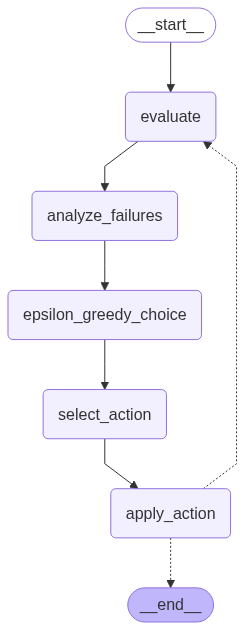

In [14]:
po = PromptOptimizer(
    failure_analysis=PromptTemplateData(
        prompt="Analyze failures in the current prompt",
        system_prompt="You are an expert in analyzing prompt failures."
    ),
    action_selection=PromptTemplateData(
        prompt="Select an improvement action based on failure analysis",
        system_prompt="You are an expert in selecting actions to improve prompts."
    ),
    action_application=PromptTemplateData(
        prompt="Apply the selected action to the current prompt",
        system_prompt="You are an expert in applying actions to improve prompts."
    )
)

po.visualize()